# Market Anomaly Detection
Detecting irregular trading days in S&P 500 data using Isolation Forest

In [75]:
#imports
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Grab data for tickers

In [76]:
tickers = ["AAPL", "MSFT", "AMZN"]
data = yf.download(tickers, start="2015-01-01", end="2025-01-01")["Close"]
data.head()

/var/folders/2z/z4pp2tsj3mzczm13nw03mb8w0000gn/T/ipykernel_97126/2844028274.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,AMZN,MSFT
Date,,,
2015-01-02,24.261047,15.4260,39.933056
2015-01-05,23.577579,15.1095,39.565834
2015-01-06,23.579796,14.7645,38.985126
2015-01-07,23.910439,14.9210,39.480442
2015-01-08,24.829128,15.0230,40.641880


Compute simple returns and plot

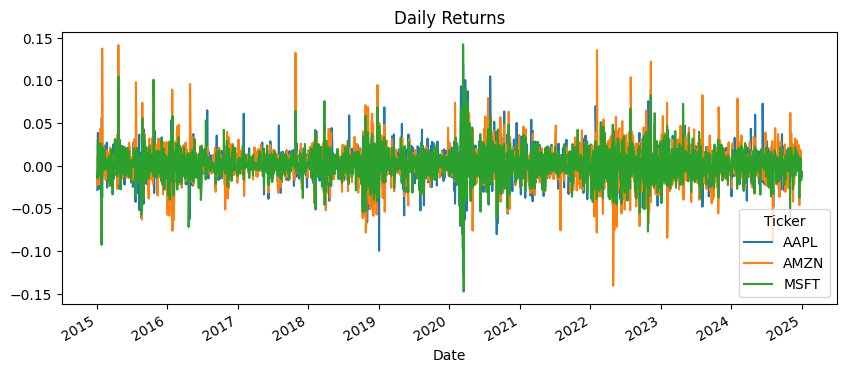

In [77]:
returns = data.pct_change().dropna()
returns.plot(figsize=(10,4))
plt.title("Daily Returns")
plt.show()

# Market Anomaly Detection using Isolation Forest

Import the required libraries, gather the data using yahoo finance.

In [78]:
import pandas as pd, numpy as np, yfinance as yf

tickers = ["AAPL","MSFT","AMZN","GOOGL","NVDA"]  # start small; swap in full list later
prices = yf.download(tickers, start="2013-01-01", end="2025-01-01", group_by="ticker", auto_adjust=False)

# helper to assemble wide frames for a field (Close, Open, High, Low, Volume)
def wide(prices, field="Close"):
    return pd.concat({t: prices[t][field] for t in tickers}, axis=1).sort_index()

close = wide(prices, "Close")
open_  = wide(prices, "Open")
vol    = wide(prices, "Volume")

print(close.head())
print(open_.head())
print(vol.head())


[*********************100%***********************]  5 of 5 completed

                 AAPL       MSFT     AMZN      GOOGL     NVDA
Date                                                         
2013-01-02  19.608213  27.620001  12.8655  18.099348  0.31800
2013-01-03  19.360714  27.250000  12.9240  18.109859  0.31825
2013-01-04  18.821428  26.740000  12.9575  18.467718  0.32875
2013-01-07  18.710714  26.690001  13.4230  18.387136  0.31925
2013-01-08  18.761070  26.549999  13.3190  18.350851  0.31225
                 AAPL       MSFT     AMZN      GOOGL     NVDA
Date                                                         
2013-01-02  19.779285  27.250000  12.8040  18.003504  0.31400
2013-01-03  19.567142  27.629999  12.8635  18.141392  0.31800
2013-01-04  19.177500  27.270000  12.8790  18.251753  0.31875
2013-01-07  18.642857  26.770000  13.1485  18.404655  0.32850
2013-01-08  18.900356  26.750000  13.3535  18.406906  0.32000
                 AAPL      MSFT      AMZN      GOOGL       NVDA
Date                                                           
2013

Clean data and prepare it for analysis.

In [79]:
ret = close.pct_change().replace([np.inf, -np.inf], np.nan)
# drop days where less than, say, 70% of tickers have data
row_valid = (ret.notna().sum(1) >= int(0.7*ret.shape[1]))
ret = ret.loc[row_valid].dropna(axis=1, how="any")

# simple winsorization
q_low, q_hi = ret.quantile(0.01), ret.quantile(0.99)
ret = ret.clip(lower=q_low, upper=q_hi, axis=1)


Map the data

In [80]:
sector_map = {
    "AAPL":"Information Technology","MSFT":"Information Technology",
    "AMZN":"Consumer Discretionary","GOOGL":"Communication Services",
    "NVDA":"Information Technology"
}


Create a matrix of features and statistics for the Isolation Forest to use.

In [81]:
def xsec_features(ret, open_, close, vol, sector_map):
    feats = []
    # align dates
    dates = ret.index

    # rolling for volume surprise
    vol_z = (vol - vol.rolling(30).median()) / (vol.rolling(30).std() + 1e-9)

    for d in dates:
        r = ret.loc[d].dropna()
        if r.empty: 
            continue
        row = {}
        row["fraction_up"] = (r > 0).mean()
        row["xsec_mean"]   = r.mean()
        row["xsec_std"]    = r.std()
        row["xsec_med"]    = r.median()
        row["p05"]         = r.quantile(0.05)
        row["p95"]         = r.quantile(0.95)

        # volume surprise (median across tickers)
        if d in vol_z.index:
            row["volsurp_med"] = vol_z.loc[d].median(skipna=True)

        # sector spreads
        if sector_map:
            df = pd.DataFrame({"ret": r})
            df["sector"] = [sector_map.get(t,"Other") for t in r.index]
            grp = df.groupby("sector")["ret"]
            row["sector_disp_meanstd"] = grp.std().mean()
            row["sector_spread_meanabs"] = (grp.mean() - df["ret"].mean()).abs().mean()

        feats.append((d, row))

    X = pd.DataFrame({k:v for k,v in feats}).T  # dict of dicts → DataFrame
    X.index = [d for d,_ in feats]
    return X.sort_index()

X = xsec_features(ret, open_, close, vol, sector_map)
X = X.dropna()


/Users/noahmcnamee/CascadeProjects/windsurf-project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/noahmcnamee/CascadeProjects/windsurf-project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/noahmcnamee/CascadeProjects/windsurf-project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/noahmcnamee/CascadeProjects/windsurf-project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/noahmcnamee/CascadeProjects/windsurf-project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeW

Remove existing anomalies from the dataset.

In [82]:
train_mask = (
    (X.index < "2020-03-01") | (X.index > "2020-07-01")
) & (
    (X.index < "2008-01-01") | (X.index > "2009-12-31")  # harmless if not in range
)

X_train = X.loc[train_mask]
X_all   = X.loc[X_train.index.min():]  # same start so scaling matches


Run the Isolation Forest model on the dataset.

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_all   = scaler.transform(X_all)

iso = IsolationForest(
    n_estimators=400,
    max_samples="auto",
    contamination=0.02,
    random_state=42
)
iso.fit(Z_train)

scores = iso.decision_function(Z_all)  # higher = more normal
pred   = iso.predict(Z_all)            # -1 anomaly, 1 normal

out = X_all.copy()
out["score"]   = scores
out["anomaly"] = (pred == -1).astype(int)


Create a plot of the Anomoly Scores vs Time.

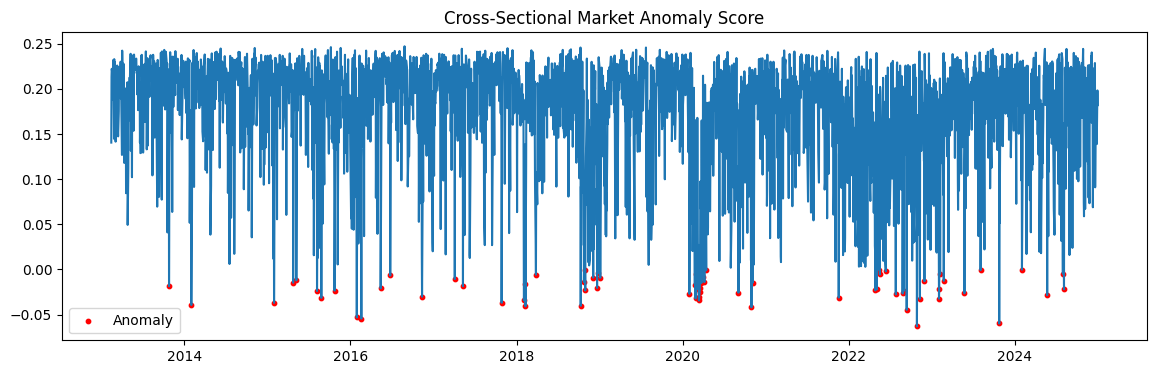

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(out.index, out["score"])
plt.scatter(out.index[out["anomaly"]==1], out.loc[out["anomaly"]==1,"score"], s=10, color="red", label="Anomaly")
plt.title("Cross-Sectional Market Anomaly Score")
plt.legend(); plt.show()


Determine what percentage of the 30 highest anomolies fall within the 2020 covid crash

In [85]:
k = 30
worst = out.nsmallest(k, "score")
precision_at_k = (worst.index.to_series().between("2020-03-01","2020-07-01")).mean()
precision_at_k


np.float64(0.1)

Save trained model for future use

In [86]:
import joblib
joblib.dump(scaler, "scaler.joblib")
joblib.dump(iso, "iso_model.joblib")
out.to_csv("market_anomaly_scores.csv")


Calculate abs_mean_return and mean_return

In [87]:
# mean absolute return across all stocks (market-wide magnitude)
out["abs_mean_return"] = ret.abs().mean(axis=1).reindex(out.index)
# or simple index return (mean of returns)
out["mean_return"] = ret.mean(axis=1).reindex(out.index)


Create graph of abs_mean_return averlapped with anomoly score with anomalies highlighted

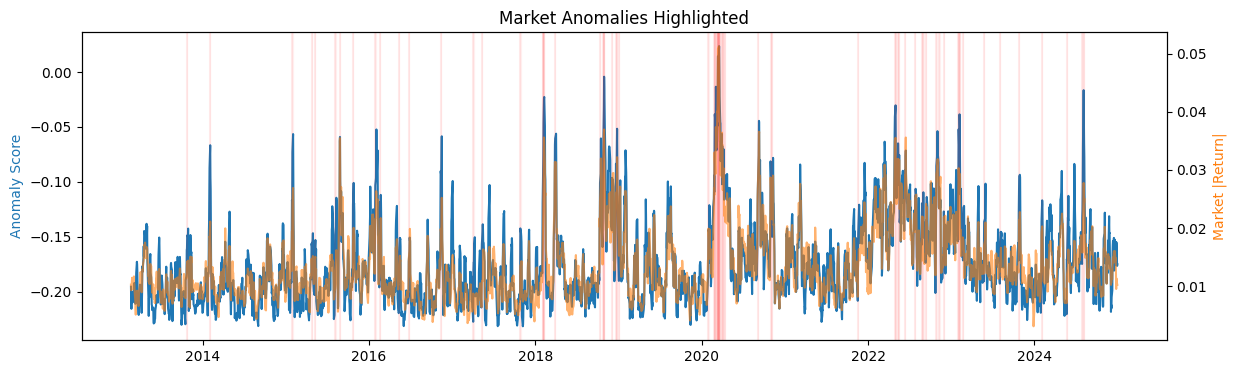

In [89]:
# ensure flipped score exists
if "score_flipped" not in out.columns:
    out["score_flipped"] = -out["score"]  # or use the MinMaxScaler version if you prefer

# smooth both series for clarity
out["score_smooth"] = out["score_flipped"].rolling(5).mean()
out["abs_mean_smooth"] = out["abs_mean_return"].rolling(5).mean()

fig, ax1 = plt.subplots(figsize=(14,4))
ax1.plot(out.index, out["score_smooth"], color="tab:blue", label="Anomaly Score (5-day)")
ax2 = ax1.twinx()
ax2.plot(out.index, out["abs_mean_smooth"], color="tab:orange", alpha=0.6, label="Market |Return| (5-day)")

# highlight anomaly windows
for date in out.index[out["anomaly"] == 1]:
    ax1.axvline(date, color="red", alpha=0.08)
for date in out.index[out["anomaly"]==1]:
    ax1.axvspan(date, date + pd.Timedelta(days=1), color="red", alpha=0.04)

ax1.set_ylabel("Anomaly Score", color="tab:blue")
ax2.set_ylabel("Market |Return|", color="tab:orange")
plt.title("Market Anomalies Highlighted")
plt.show()



Create plot of abs_mean_return and score

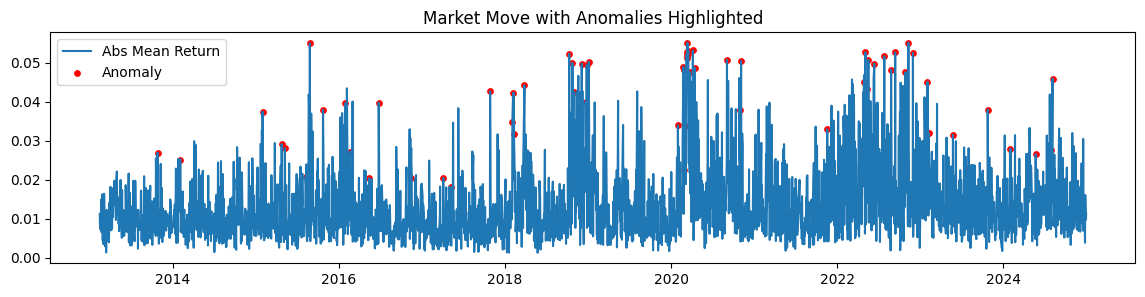

In [ ]:
anoms = out[out["anomaly"]==1].index
plt.figure(figsize=(14,3))
plt.plot(out.index, out["abs_mean_return"], label="Abs Mean Return")
plt.scatter(anoms, out.loc[anoms,"abs_mean_return"], color="red", s=15, label="Anomaly")
plt.legend()
plt.title("Market Move with Anomalies Highlighted")
plt.show()


Return the correlation of the abs mean return of the stocks and the anomoly score.

In [ ]:
out[["abs_mean_return","score"]].corr()


,abs_mean_return,score
abs_mean_return,1.000000,-0.853787
score,-0.853787,1.000000


Overlay anomolies and the total return of each stock.

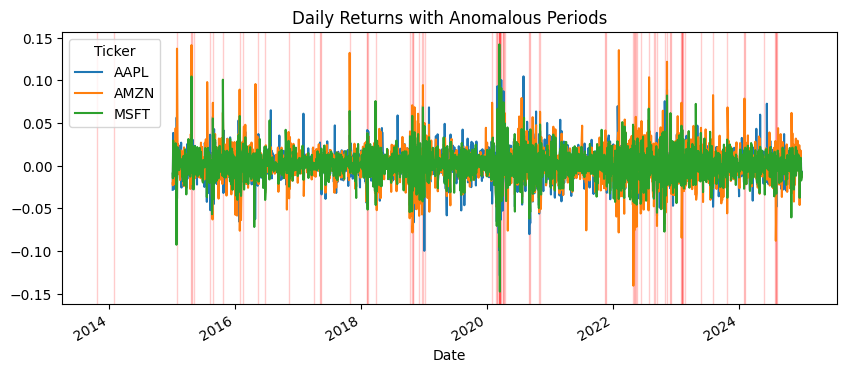

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

returns.plot(ax=ax)
ax.set_title("Daily Returns with Anomalous Periods")

for date in out.index[out["anomaly"] == 1]:
    ax.axvspan(date, date + pd.Timedelta(days=1), color="red", alpha=0.2)

plt.show()
